In [ ]:
!nvidia-smi

Fri Dec 10 22:06:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive._mount("/content/drive")

import os
os.chdir("/content/drive/My Drive/Computer Vision 2021")

!ls
!rm -rf /data
!mkdir /data
!cp train2017_custom2.zip /data
!cp val2017_custom2.zip /data

os.chdir("/data")
!ls

!unzip train2017_custom2.zip > /dev/null
!unzip val2017_custom2.zip > /dev/null

!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip annotations_trainval2017.zip
!cp annotations/instances_train2017.json .
!cp annotations/instances_val2017.json .

!rm -rf annotations/
!rm *.zip

!ls

Mounted at /content/drive
 COCO-val2014-BBox-Results.gsheet
 fcn_test_10.pth
 fcn_test_scratch_10.pth
 fcn_test_scratch_15.pth
 fcn_test_scratch_data_augment_20.pth
 fcn_test_scratch_data_augment_dice_loss_10.pth
 fcn_test_scratch_data_augment_focal_loss_10.pth
 fcn_test_scratch_data_augment_focal_loss_v2_10.pth
 fcn_test_scratch_data_augment_focal_loss_v2_20.pth
 fcn_test_scratch_data_augment_v2_10.pth
 fcn_test_scratch_data_augment_v2_20.pth
 fcn_test_scratch_v2_10.pth
'Final Project.gdoc'
'Final Report Template.gdoc'
'Progress Report.gdoc'
'Project Proposal (Computer Vision 2021):.gdoc'
 segnet_20.pth
 segnet_30.pth
 segnet_40.pth
 segnet_60.pth
 segnet_focal_loss_10.pth
 segnet_focal_loss_40.pth
 segnet_focal_loss_60.pth
 segnet_test.pth
 train2017_custom2.zip
 train2017_custom.zip
'Useful Links.gdoc'
 val2017_custom2.zip
 val2017_custom.zip
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
train2017_custom2.zip  val

In [ ]:
!df -h
import os
os.chdir("/data")
!ls

Filesystem      Size  Used Avail Use% Mounted on
overlay         167G   46G  121G  28% /
tmpfs            64M     0   64M   0% /dev
shm             5.7G     0  5.7G   0% /dev/shm
/dev/root       2.0G  1.2G  821M  59% /sbin/docker-init
tmpfs           6.4G   36K  6.4G   1% /var/colab
/dev/sda1       174G   52G  122G  30% /opt/bin/.nvidia
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive           167G   52G  115G  32% /content/drive
instances_train2017.json  train2017_custom_2
instances_val2017.json	  val2017_custom_2


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader

from pycocotools.coco import COCO

from PIL import Image

import numpy as np
import random

import os
import tqdm

import matplotlib
import matplotlib.pyplot as plt

!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

%matplotlib inline

     |████████████████████████████████| 88 kB 4.6 MB/s 
     |████████████████████████████████| 376 kB 10.5 MB/s 
     |████████████████████████████████| 58 kB 6.0 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=d9d980bf9aac7411d1d07b2cf06fdc73e83b5979567c628a87413092885916a8
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=7a3cab3b6d5b1a1ff7237449c23c23d196aed430d75f729fbce5b758dc28dce7
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
cuda


In [ ]:
CATEGORIES = [
            "airplane",
            "bicycle",
            "bird",
            "boat",
            "bottle",
            "bus",
            "car",
            "cat",
            "chair",
            "cow",
            "dining table",
            "dog",
            "horse",
            "motorcycle",
            "person",
            "potted plant",
            "sheep",
            "couch",
            "train",
            "tv"
        ]
CATEGORIES = sorted(CATEGORIES)

class CustomDataset(Dataset):

    def __init__(self, image_folder_path,
                       annotations_file,
                       augment=False):
        self.augment = augment
        self.image_folder_path = image_folder_path
        self.coco = COCO(annotations_file)

        self.image_ids = []
        for image_id in self.coco.imgs:
            fname = self.coco.imgs[image_id]["file_name"]
            fpath = os.path.join(image_folder_path, fname)

            if os.path.isfile(fpath):
                self.image_ids.append(image_id)

        categories = self.coco.loadCats(self.coco.getCatIds())

        category_names_to_ids = {}
        for c in categories:
            category_names_to_ids[c["name"]] = c["id"]

        self.category_ids = []
        for c in CATEGORIES:
            self.category_ids.append(category_names_to_ids[c])

        self.category_id_mapping = {}
        self.category_id_mapping[0] = 0
        for i in range(len(CATEGORIES)):
            self.category_id_mapping[category_names_to_ids[CATEGORIES[i]]] = i + 1

        print(category_names_to_ids)
        print(self.category_id_mapping)

        assert len(self.category_ids) == len(CATEGORIES), len(self.category_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        fname = self.coco.imgs[img_id]["file_name"]
        img_path = os.path.join(self.image_folder_path, fname)

        img = Image.open(img_path).convert("RGB")

        anns_ids = self.coco.getAnnIds(imgIds=img_id, catIds=self.category_ids, iscrowd=None)
        anns = self.coco.loadAnns(anns_ids)

        W, H = img.size
        mask = np.zeros((H, W))
        for ann in anns:
            mask = np.maximum(mask, self.coco.annToMask(ann) * self.category_id_mapping[ann["category_id"]])
        
        mask = torch.from_numpy(mask)

        img = TF.to_tensor(img)

        resize = transforms.Resize(size=(256, 256))
        img = resize(img)
        mask = resize(mask.unsqueeze(0)).squeeze()

        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        img = normalize(img)

        if self.augment:
          if random.random() > 0.5:
              img = TF.hflip(img)
              mask = TF.hflip(mask)

          if random.random() > 0.5:
              img = TF.vflip(img)
              mask = TF.vflip(mask)

        return img, mask

    def __len__(self):
        return len(self.image_ids)

In [ ]:
train_dataset = CustomDataset(image_folder_path="/data/train2017_custom_2", annotations_file="/data/instances_train2017.json", augment=True)
val_dataset = CustomDataset(image_folder_path="/data/val2017_custom_2", annotations_file="/data/instances_val2017.json")

loading annotations into memory...
Done (t=16.64s)
creating index...
index created!
{'person': 1, 'bicycle': 2, 'car': 3, 'motorcycle': 4, 'airplane': 5, 'bus': 6, 'train': 7, 'truck': 8, 'boat': 9, 'traffic light': 10, 'fire hydrant': 11, 'stop sign': 13, 'parking meter': 14, 'bench': 15, 'bird': 16, 'cat': 17, 'dog': 18, 'horse': 19, 'sheep': 20, 'cow': 21, 'elephant': 22, 'bear': 23, 'zebra': 24, 'giraffe': 25, 'backpack': 27, 'umbrella': 28, 'handbag': 31, 'tie': 32, 'suitcase': 33, 'frisbee': 34, 'skis': 35, 'snowboard': 36, 'sports ball': 37, 'kite': 38, 'baseball bat': 39, 'baseball glove': 40, 'skateboard': 41, 'surfboard': 42, 'tennis racket': 43, 'bottle': 44, 'wine glass': 46, 'cup': 47, 'fork': 48, 'knife': 49, 'spoon': 50, 'bowl': 51, 'banana': 52, 'apple': 53, 'sandwich': 54, 'orange': 55, 'broccoli': 56, 'carrot': 57, 'hot dog': 58, 'pizza': 59, 'donut': 60, 'cake': 61, 'chair': 62, 'couch': 63, 'potted plant': 64, 'bed': 65, 'dining table': 67, 'toilet': 70, 'tv': 72, '

In [ ]:
BATCH_SIZE = 16

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

def show_images(img, label, prediction=None):
  if prediction is not None:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
  else:
    fig, (ax1, ax2) = plt.subplots(1, 2)

  ax1.imshow(img.cpu().squeeze().permute(1, 2, 0))
  ax1.set_title("Input image")

  _, W, H = img.size()

  r = Image.fromarray(label.byte().cpu().numpy()).resize((W, H))
  r.putpalette(colors)
  ax2.imshow(r)
  ax2.set_title("Ground truth")

  if prediction is not None:
    r = Image.fromarray(prediction.byte().cpu().numpy()).resize((W, H))
    r.putpalette(colors)
    ax3.imshow(r)
    ax3.set_title("Prediction")
  plt.show()

In [ ]:
def save_state(name, curr_epoch, model, optim, curr_loss, folder="/content/drive/My Drive/Computer Vision 2021"):
  path = os.path.join(folder, name)
  state = {"epoch": curr_epoch,
           "loss": curr_loss,
           "model_state_dict": model.state_dict(),
           "optimizer_state_dict": optim.state_dict()}
  torch.save(state, path)


def load_state(name, model, optim, folder="/content/drive/My Drive/Computer Vision 2021"):
  path = os.path.join(folder, name)
  state = torch.load(path)
  model.load_state_dict(state["model_state_dict"])
  optim.load_state_dict(state["optimizer_state_dict"])
  return state["epoch"], state["loss"]


def validate(model, validation_dataloader):
  model.eval()
  rv = 0

  with torch.no_grad():
    for i, (imgs, labels) in tqdm.tqdm(enumerate(validation_dataloader), total=len(validation_dataloader)):
      imgs = imgs.to(device)
      labels = labels.type(torch.LongTensor).to(device)
      
      predictions = model(imgs)
      curr_loss = criterion(predictions, labels)
      rv += curr_loss.item()

      if i == 0:
        show_images(imgs[0], labels[0], predictions[0].argmax(0))

      del curr_loss
      del predictions
      del imgs
      del labels
      
    rv /= len(validation_dataloader)
    return rv

In [ ]:
# From https://github.com/kornia/kornia/blob/master/kornia/losses/focal.py

def one_hot(
    labels,
    num_classes,
    device = None,
    dtype = None,
    eps: float = 1e-6,
):
    if not isinstance(labels, torch.Tensor):
        raise TypeError(f"Input labels type is not a torch.Tensor. Got {type(labels)}")

    if not labels.dtype == torch.int64:
        raise ValueError(f"labels must be of the same dtype torch.int64. Got: {labels.dtype}")

    if num_classes < 1:
        raise ValueError("The number of classes must be bigger than one." " Got: {}".format(num_classes))

    shape = labels.shape
    one_hot = torch.zeros((shape[0], num_classes) + shape[1:], device=device, dtype=dtype)

    return one_hot.scatter_(1, labels.unsqueeze(1), 1.0) + eps

def focal_loss(
    input,
    target,
    alpha,
    gamma = 2.0,
    reduction = "none",
    eps = None,
):
    if eps is not None and not torch.jit.is_scripting():
        warnings.warn(
            "`focal_loss` has been reworked for improved numerical stability "
            "and the `eps` argument is no longer necessary",
            DeprecationWarning,
            stacklevel=2,
        )

    if not isinstance(input, torch.Tensor):
        raise TypeError(f"Input type is not a torch.Tensor. Got {type(input)}")

    if not len(input.shape) >= 2:
        raise ValueError(f"Invalid input shape, we expect BxCx*. Got: {input.shape}")

    if input.size(0) != target.size(0):
        raise ValueError(f"Expected input batch_size ({input.size(0)}) to match target batch_size ({target.size(0)}).")

    n = input.size(0)
    out_size = (n,) + input.size()[2:]
    if target.size()[1:] != input.size()[2:]:
        raise ValueError(f"Expected target size {out_size}, got {target.size()}")

    if not input.device == target.device:
        raise ValueError(f"input and target must be in the same device. Got: {input.device} and {target.device}")

    # compute softmax over the classes axis
    input_soft = F.softmax(input, dim=1)
    log_input_soft = F.log_softmax(input, dim=1)

    # create the labels one hot tensor
    target_one_hot = one_hot(target, num_classes=input.shape[1], device=input.device, dtype=input.dtype)

    # compute the actual focal loss
    weight = torch.pow(-input_soft + 1.0, gamma)

    focal = -alpha * weight * log_input_soft
    loss_tmp = torch.einsum("bc...,bc...->b...", (target_one_hot, focal))

    if reduction == "none":
        loss = loss_tmp
    elif reduction == "mean":
        loss = torch.mean(loss_tmp)
    elif reduction == "sum":
        loss = torch.sum(loss_tmp)
    else:
        raise NotImplementedError(f"Invalid reduction mode: {reduction}")
    return loss


class FocalLoss(nn.Module):
    def __init__(self, alpha, gamma=2.0, reduction="mean", eps=None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.eps = eps

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        return focal_loss(input, target, self.alpha, self.gamma, self.reduction, self.eps)

In [ ]:
model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=21)
model = model.to(device)

In [ ]:
EPOCHS = 10
LEARNING_RATE = 0.0003

#criterion = nn.CrossEntropyLoss()
criterion = FocalLoss(0.25)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

running_losses = []
epoch = 0

40


  0%|          | 0/486 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


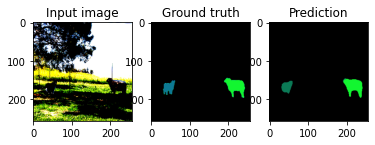

  0%|          | 0/186 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


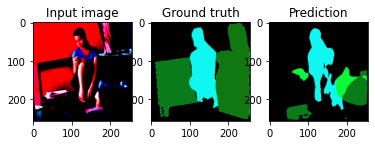

100%|██████████| 186/186 [01:09<00:00,  2.68it/s]


Epoch 40, Running Loss: 0.041205538195316437, Validation Loss: 0.0903485826847534


  0%|          | 0/486 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


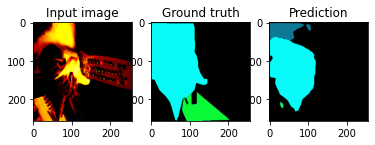

  0%|          | 0/186 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


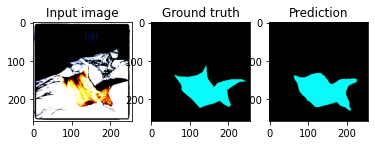

100%|██████████| 186/186 [01:10<00:00,  2.64it/s]


Epoch 41, Running Loss: 0.039178441723218424, Validation Loss: 0.09434878423569663


  0%|          | 0/486 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


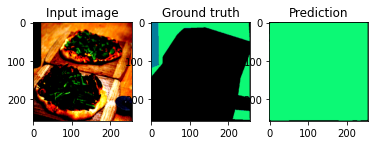

  0%|          | 0/186 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


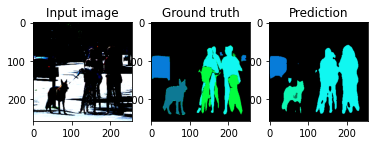

100%|██████████| 186/186 [01:09<00:00,  2.69it/s]


Epoch 42, Running Loss: 0.04139338007557049, Validation Loss: 0.09464412040367562


  0%|          | 0/486 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


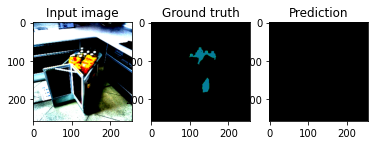

  0%|          | 0/186 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


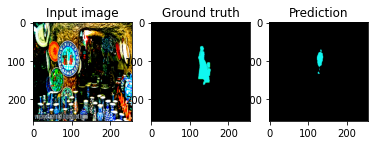

100%|██████████| 186/186 [01:09<00:00,  2.68it/s]


Epoch 43, Running Loss: 0.04109779933904424, Validation Loss: 0.08907235057283473


  0%|          | 0/486 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


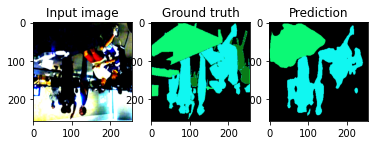

  0%|          | 0/186 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


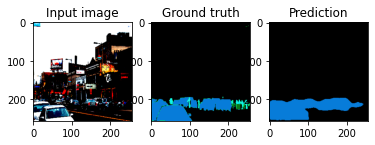

100%|██████████| 186/186 [01:10<00:00,  2.65it/s]


Epoch 44, Running Loss: 0.03814234730208852, Validation Loss: 0.0933953225412356


  0%|          | 0/486 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


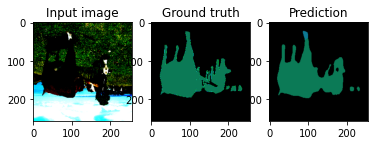

  0%|          | 0/186 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


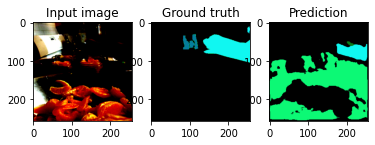

100%|██████████| 186/186 [01:10<00:00,  2.63it/s]


Epoch 45, Running Loss: 0.03787400990479277, Validation Loss: 0.09112281570591593


  0%|          | 0/486 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


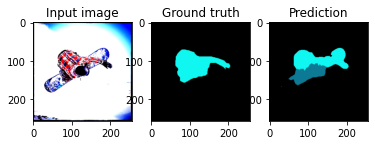

  0%|          | 0/186 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


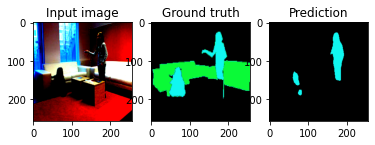

100%|██████████| 186/186 [01:11<00:00,  2.61it/s]


Epoch 46, Running Loss: 0.03660615628638876, Validation Loss: 0.09559735549633862


  0%|          | 0/486 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


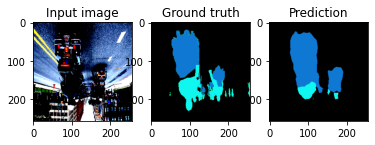

  0%|          | 0/186 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


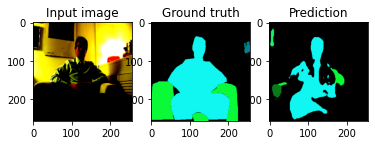

100%|██████████| 186/186 [01:11<00:00,  2.60it/s]


Epoch 47, Running Loss: 0.03767221643677587, Validation Loss: 0.09223001696650059


  0%|          | 0/486 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


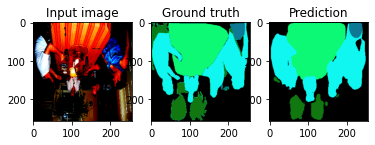

  0%|          | 0/186 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


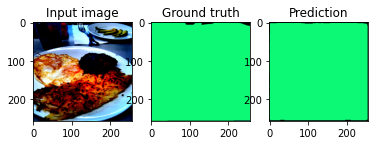

100%|██████████| 186/186 [01:09<00:00,  2.67it/s]


Epoch 48, Running Loss: 0.036355399131897545, Validation Loss: 0.09201717392731738


  0%|          | 0/486 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


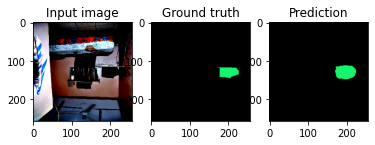

  0%|          | 0/186 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


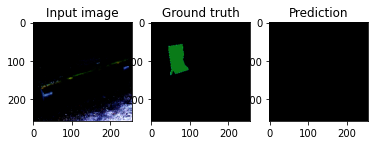

100%|██████████| 186/186 [01:10<00:00,  2.62it/s]


Epoch 49, Running Loss: 0.0349290170036103, Validation Loss: 0.09667240680065206


  0%|          | 0/486 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


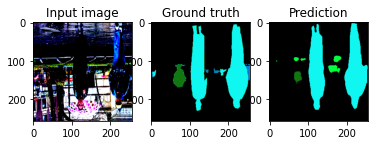

  0%|          | 0/186 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


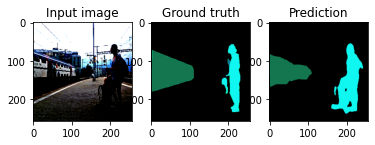

100%|██████████| 186/186 [01:09<00:00,  2.66it/s]


Epoch 50, Running Loss: 0.03578663024085539, Validation Loss: 0.09797312252183435


  0%|          | 0/486 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


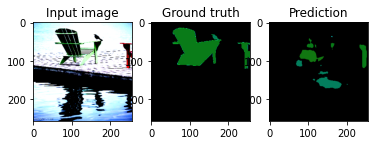

  0%|          | 0/186 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


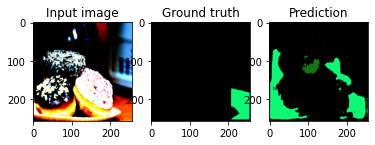

100%|██████████| 186/186 [01:09<00:00,  2.66it/s]


Epoch 51, Running Loss: 0.036122697662301514, Validation Loss: 0.10076966086122137


  0%|          | 0/486 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


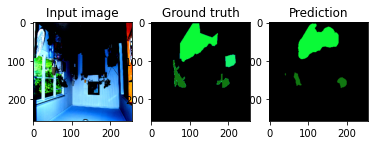

  0%|          | 0/186 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


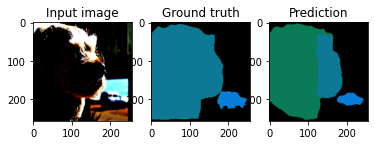

100%|██████████| 186/186 [01:10<00:00,  2.65it/s]


Epoch 52, Running Loss: 0.03687997583161901, Validation Loss: 0.09339853055695052


  0%|          | 0/486 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


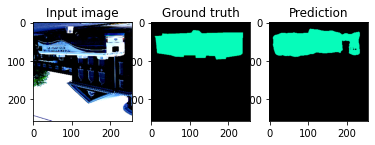

  0%|          | 0/186 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


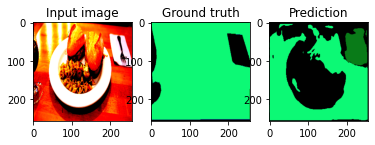

100%|██████████| 186/186 [01:11<00:00,  2.62it/s]


Epoch 53, Running Loss: 0.034778373660864656, Validation Loss: 0.09546897954918364


  0%|          | 0/486 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


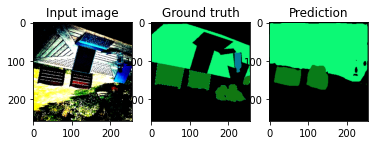

  0%|          | 0/186 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


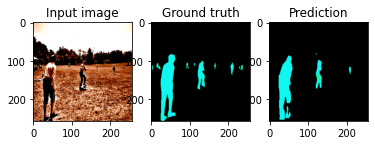

100%|██████████| 186/186 [01:08<00:00,  2.70it/s]


Epoch 54, Running Loss: 0.03265267813294635, Validation Loss: 0.09785628629227479


  0%|          | 0/486 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


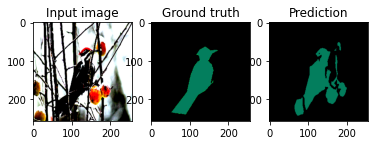

  0%|          | 0/186 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


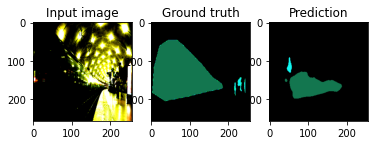

100%|██████████| 186/186 [01:10<00:00,  2.65it/s]


Epoch 55, Running Loss: 0.03503249322711931, Validation Loss: 0.10052540345663225


  0%|          | 0/486 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


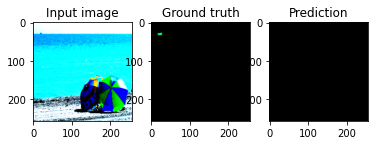

  0%|          | 0/186 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


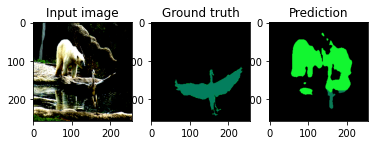

100%|██████████| 186/186 [01:09<00:00,  2.67it/s]


Epoch 56, Running Loss: 0.03447161102475821, Validation Loss: 0.10293927660552404


  0%|          | 0/486 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


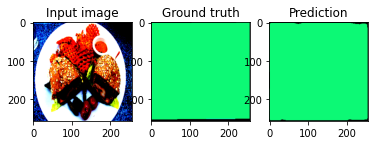

  0%|          | 0/186 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


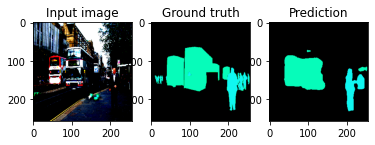

100%|██████████| 186/186 [01:14<00:00,  2.49it/s]


Epoch 57, Running Loss: 0.03415029298192189, Validation Loss: 0.10214378482471871


  0%|          | 0/486 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


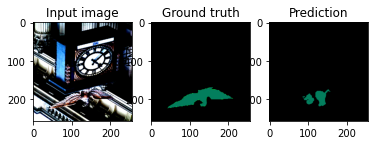

  0%|          | 0/186 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


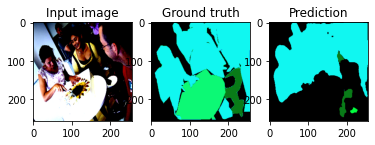

100%|██████████| 186/186 [01:11<00:00,  2.60it/s]


Epoch 58, Running Loss: 0.03236311119923621, Validation Loss: 0.10406471602618694


  0%|          | 0/486 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


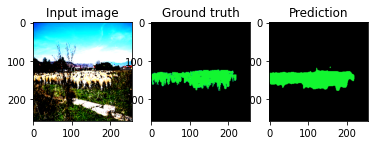

  0%|          | 0/186 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


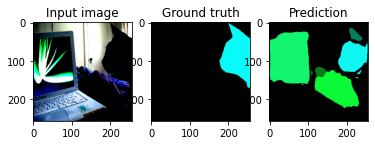

100%|██████████| 186/186 [01:13<00:00,  2.55it/s]

Epoch 59, Running Loss: 0.03232471482376012, Validation Loss: 0.09773675651009124


In [ ]:
EPOCHS = 60
print(epoch)
while epoch < EPOCHS:
  model.train()

  running_loss = 0

  for i, (imgs, labels) in tqdm.tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
    imgs = imgs.to(device)
    labels = labels.type(torch.LongTensor).to(device)

    optimizer.zero_grad()
    
    predictions = model(imgs)

    loss = criterion(predictions, labels)
    running_loss += loss.item()
    loss.backward()
    
    optimizer.step()

    if i == 0:
      show_images(imgs[0], labels[0], predictions[0].argmax(0))

    del loss
    del predictions
    del imgs
    del labels

  running_loss /= len(train_dataloader)
  running_losses.append(running_loss)

  val_loss = validate(model, val_dataloader)
  print(f"Epoch {epoch}, Running Loss: {running_loss}, Validation Loss: {val_loss}")
  epoch += 1

In [ ]:
save_state("unet_focal_60.pth", epoch, model, optimizer, running_losses)